In [89]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from IPython.display import clear_output
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
from tqdm.notebook import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from graphviz import Source
from sklearn.tree import export_graphviz


from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
#from catboost import CatBoostClassifier
# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
# from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

# import optuna

import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import torch.optim as optim
import math

np.random.seed(42)

plt.rcParams.update({"font.size": 16})
sns.set_style("whitegrid")
np.random.seed(0xFA1AFE1)

# Загрузка, очисткка и предобработка данных
Воспользуемся частично той же предобработкой, которую мы использовали для случайного леса

In [90]:
df = pd.read_excel("df_filtered.xlsx")

# Исключаем слишком большие квартиры (> 200 кв.м)
df_cleaned = df[df['Общая площадь'] <= 200]

# Ограничиваем этажность (максимум 50 этажей)
df_cleaned = df_cleaned[df_cleaned['Этаж'] <= 50]

# Убираем здания старше 100 лет
current_year = pd.Timestamp.now().year
df_cleaned = df_cleaned[df_cleaned['Год постройки'] >= (current_year - 100)]

# Ограничиваем высоту потолков (не более 5 м)
df_cleaned = df_cleaned[df_cleaned['Высота потолков'] <= 5]

# Исключаем элитные квартиры (> 100 млн руб.)
df_cleaned = df_cleaned[df_cleaned['Цена'] <= 100000000]

# Убираем слишком большие кухни (> 50 кв.м)
df_cleaned = df_cleaned[df_cleaned['Площадь кухни'] <= 50]

X = df_cleaned.drop(columns=['Цена'])
y = df_cleaned['Цена']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Посмотрим на распределение цены

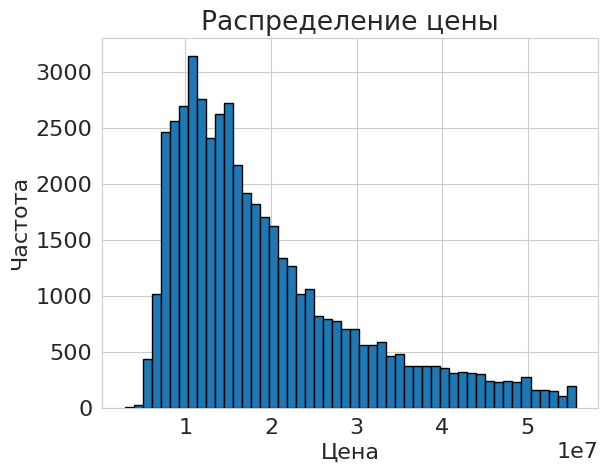

In [ ]:
import matplotlib.pyplot as plt

plt.hist(y, bins=50, edgecolor='black')
plt.title('Распределение цены')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

Распределение скошено - попробуем логнормировать

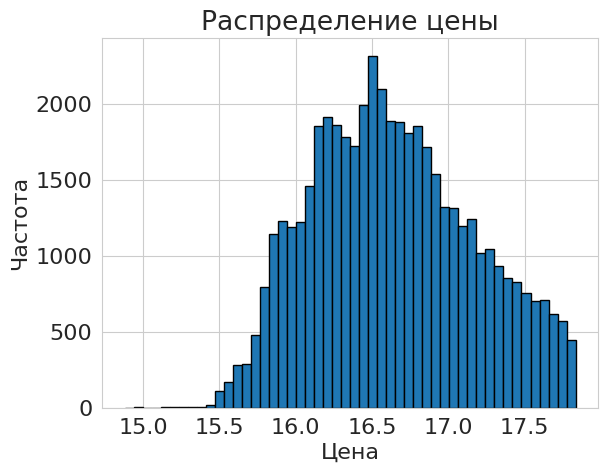

In [ ]:
import matplotlib.pyplot as plt

plt.hist(np.log(y), bins=50, edgecolor='black')
plt.title('Распределение цены')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

Масштабируем целевую переменную

In [18]:
def normalize_train(sample, scaler):
    """
    Min-max normalization to convert sample to [0, 1]/(mu=1,var=0) range
    """
    scaled_feature = scaler.fit_transform(sample)
    return scaled_feature

def normalize_test(sample, scaler):
    scaled_feature = scaler.transform(sample)
    return scaled_feature

def denormalize(sample, scaler):
    """
    Denormalize sample from [0, 1]/(mu=1,var=0) to initial range
    """
    sample_np = sample.detach().cpu().numpy()
    if sample_np.ndim == 1:
        sample_np = sample_np.reshape(-1, 1)
    unscaled_feature = scaler.inverse_transform(sample_np)
    return torch.tensor(unscaled_feature, dtype=torch.float32, device=sample.device)

In [51]:
y_scaler = MinMaxScaler()

# масштабируем y_train
y_train_log = np.log(y_train).values.reshape(-1, 1)
y_train_scaled = y_scaler.fit_transform(y_train_log)

# масштабируем y_test
y_test_log = np.log(y_test).values.reshape(-1, 1)
y_test_scaled = y_scaler.transform(y_test_log)

In [119]:
df.describe(include=['object', 'category'])

,Кол-во комнат,Ремонт,Материал стен,Тип жилья,Станция
count,77551,77551,77551,77551,77551
unique,7,8,6,2,285
top,2,Без отделки,монолит,квартира,Коммунарка
freq,26220,38501,48353,71320,3473


Закодируем категориальные признаки LabelEncoder

In [106]:
categorical_features = df.select_dtypes(include=['object', 'category']).columns
X_train[categorical_features]

,Кол-во комнат,Ремонт,Материал стен,Тип жилья,Станция
17973,1,1,3,1,192
6694,0,0,3,1,78
58800,3,5,3,1,71
43386,2,0,3,1,145
44667,2,0,3,1,114
...,...,...,...,...,...
16238,1,0,3,1,119
72937,4,0,3,1,122
59621,3,2,3,1,24
1247,0,0,3,1,80


In [107]:
encoders = {}
num_categories = {} # для категориальных эмбеддингов

for cat in categorical_features:
    X_train[cat] = X_train[cat].astype(str)
    X_test[cat]  = X_test[cat].astype(str)
    all_train = X_train[cat].tolist() + ['__UNK__'] # для корректной обработки неизвестных значений в тесте
    le = LabelEncoder().fit(all_train)
    X_train[cat] = le.transform(X_train[cat])
    X_test[cat]  = le.transform(
        X_test[cat].map(lambda x: x if x in le.classes_ else '__UNK__')
    )
    encoders[cat] = le
    num_categories[cat] = len(le.classes_)

emb_dims = {}  # для категориальных эмбеддингов
for cat in categorical_features:
    c = num_categories[cat]
    emb_dims[cat] = min(50, round(c ** 0.5))
    print(f"{cat}: {c} уникальных значений, embedding dim = {emb_dims[cat]}")

Кол-во комнат: 8 уникальных значений, embedding dim = 3
Ремонт: 9 уникальных значений, embedding dim = 3
Материал стен: 6 уникальных значений, embedding dim = 2
Тип жилья: 3 уникальных значений, embedding dim = 2
Станция: 217 уникальных значений, embedding dim = 15


Масштабируем числовые признаки в X_train, X_test

In [109]:
numeric_features = df.select_dtypes(include=['number']).columns
numeric_features = numeric_features.drop('Цена')
numeric_features

Index(['Расстояние до центра', 'Общая площадь', 'Этаж', 'Год постройки',
       'Высота потолков', 'Площадь кухни', 'Время'],
      dtype='object')

In [110]:
scaler_X = StandardScaler()

X_train_scaled = X_train.copy()
X_train_numeric_scaled = scaler_X.fit_transform(X_train[numeric_features])
X_train_scaled[numeric_features] = X_train_numeric_scaled

X_test_scaled = X_test.copy()
X_test_numeric_scaled = scaler_X.transform(X_test[numeric_features])
X_test_scaled[numeric_features] = X_test_numeric_scaled

# Обучаем сеть

Train & validate поможет нам запускать эксперименты. Также реализовал поддержку обучения на GPU, чтобы эксперименты считались быстрее (тренировал модель в Google Colab)

Для категориальных признаков заведем эмбединги размером 4-16

Причины следующие

*  Плотное, низкоразмерное представление: меньше параметров на вход --> быстрее обучение и меньше риска переобучения
*  Учет семантических связей между категориями
*  Эффективнее по памяти чем OneHot

In [111]:
def plot_losses(train_losses, train_metrics, val_losses, val_metrics):
    """
    Plot losses and metrics while training
      - train_losses: sequence of train losses
      - train_metrics: sequence of train MSE values
      - val_losses: sequence of validation losses
      - val_metrics: sequence of validation MSE values
    """
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label="train")
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label="val")
    axs[1].plot(range(1, len(train_metrics) + 1), train_metrics, label="train")
    axs[1].plot(range(1, len(val_metrics) + 1), val_metrics, label="val")

    if max(train_losses) / min(train_losses) > 10:
        axs[0].set_yscale("log")

    if max(train_metrics) / min(train_metrics) > 10:
        axs[1].set_yscale("log")

    for ax in axs:
        ax.set_xlabel("epoch")
        ax.legend()

    axs[0].set_ylabel("loss")
    axs[1].set_ylabel("MSE")
    plt.show()


def train_and_validate(
    model,
    optimizer,
    criterion,
    metric,
    train_loader,
    val_loader,
    num_epochs,
    verbose=True,
):
    """
    Train and validate neural network
      - model: neural network to train
      - optimizer: optimizer chained to a model
      - criterion: loss function class
      - metric: function to measure MSE taking neural networks predictions
                 and ground truth labels
      - train_loader: DataLoader with train set
      - val_loader: DataLoader with validation set
      - num_epochs: number of epochs to train
      - verbose: whether to plot metrics during training
    Returns:
      - train_mse: training MSE over the last epoch
      - val_mse: validation MSE after the last epoch
    """
    train_losses, val_losses = [], []
    train_metrics, val_metrics = [], []

    device = torch.device("cuda") #буду использовать GPU в коллабе
    model.to(device)

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss, running_metric = 0, 0
        pbar = (
            tqdm(train_loader, desc=f"Training {epoch}/{num_epochs}")
            if verbose
            else train_loader
        )

        for i, batch in enumerate(pbar, 1):
            batch_size = next(iter(batch.values())).shape[0]
            for key in batch:
                batch[key] = batch[key].to(device)
            predictions = model(batch)
            y_batch = batch['target'].unsqueeze(1)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            with torch.no_grad():
                metric_value = metric(predictions, y_batch)
                if type(metric_value) == torch.Tensor:
                    metric_value = metric_value.item()

                running_loss += loss.item() * batch_size
                running_metric += metric_value * batch_size

            if verbose and i % 100 == 0:
                pbar.set_postfix({"loss": loss.item(), "MSE": metric_value})
                print(predictions[:2], y_batch[:2])

        train_losses += [running_loss / len(train_loader.dataset)]
        train_metrics += [running_metric / len(train_loader.dataset)]


        model.eval()
        running_loss, running_metric = 0, 0
        pbar = (
            tqdm(val_loader, desc=f"Validating {epoch}/{num_epochs}")
            if verbose
            else val_loader
        )

        for i, batch in enumerate(pbar, 1):
            batch_size = next(iter(batch.values())).shape[0]
            for key in batch:
                batch[key] = batch[key].to(device)
            y_batch = batch['target'].unsqueeze(1)
            with torch.no_grad():
                predictions = model(batch)
                loss = criterion(predictions, y_batch)
                metric_value = metric(predictions, y_batch)
                if type(metric_value) == torch.Tensor:
                    metric_value = metric_value.item()
                running_loss += loss.item() * batch_size
                running_metric += metric_value * batch_size

            if verbose and i % 100 == 0:
                pbar.set_postfix({"loss": loss.item(), "MSE": metric_value})

        val_losses += [running_loss / len(val_loader.dataset)]
        val_metrics += [running_metric / len(val_loader.dataset)]

        if verbose:
            plot_losses(train_losses, train_metrics, val_losses, val_metrics)

    if verbose:
        print(f"Validation MSE: {val_metrics[-1]:.3f}")

    return train_metrics[-1], val_metrics[-1]

Создадим простую нейронную сеть

*   Архитектура -  несколько линейных слоев (2 с ReLU активацией)
*   SGD lr=1e-2
*   batch_size=32
*   также обернем категориальные признаки в эмбеддинги и используем в обучении вместе с числовыми признаками с индивидуально подобранной размерностью для каждой категории
* 	Dropout применяется для регуляризации и предотвращения переобучения - отключает примерно 20% нейронов на каждом проходе)
*   тк задача регрессии - не используем Sigmoid (она ограничивает выходы модели в рамках 0 и 1)

In [112]:
class LinearNetSigmoidEnhancedDropOut(nn.Module):
    def __init__(self):
        super().__init__()
        #создаем эмбединги под категории
        self.rooms_emb = nn.Embedding(num_categories['Кол-во комнат'], emb_dims['Кол-во комнат'])
        self.remont_emb = nn.Embedding(num_categories['Ремонт'], emb_dims['Ремонт'])
        self.wall_emb = nn.Embedding(num_categories['Материал стен'], emb_dims['Материал стен'])
        self.type_emb = nn.Embedding(num_categories['Тип жилья'], emb_dims['Тип жилья'])
        self.station_emb = nn.Embedding(num_categories['Станция'], emb_dims['Станция'])

        total_emb_dim = (emb_dims['Кол-во комнат'] + emb_dims['Ремонт'] +
            emb_dims['Материал стен'] + emb_dims['Тип жилья'] + emb_dims['Станция'])

        num_numeric = len(numeric_features)

        input_dim = total_emb_dim + num_numeric

        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1)
        )

    def forward(self, batch):
        # Эмбеддинги категориальных признаков
        rooms_emb = self.rooms_emb(batch['Кол-во комнат'])
        remont_emb = self.remont_emb(batch['Ремонт'])
        wall_emb = self.wall_emb(batch['Материал стен'])
        type_emb = self.type_emb(batch['Тип жилья'])
        station_emb = self.station_emb(batch['Станция'])

        cat_emb = torch.cat([rooms_emb, remont_emb, wall_emb, type_emb, station_emb], dim=1)

        num_feats = torch.stack([
            batch['Расстояние до центра'],
            batch['Общая площадь'],
            batch['Этаж'],
            batch['Год постройки'],
            batch['Высота потолков'],
            batch['Площадь кухни'],
            batch['Время'],
        ], dim=1) #не включаю цену

        x_combined = torch.cat([cat_emb, num_feats], dim=1)

        return self.model(x_combined)

чтобы удобно обращаться к колонкам (тк дефолтный TensorDataset убирает названия колонок)
создадим свой класс MyDataset, в рамках него можно будет обращаться к данным по названиям колонок.

In [113]:
class MyDataset(Dataset):
    def __init__(self, df, target_col):
        self.features = df.drop(columns=[target_col])
        self.targets = df[target_col]

    def __getitem__(self, idx):
        row = self.features.iloc[idx]
        return {
            # Категориальные признаки — уже закодированы, но названия прежние
            'Кол-во комнат': torch.tensor(row['Кол-во комнат'], dtype=torch.long),
            'Ремонт': torch.tensor(row['Ремонт'], dtype=torch.long),
            'Материал стен': torch.tensor(row['Материал стен'], dtype=torch.long),
            'Тип жилья': torch.tensor(row['Тип жилья'], dtype=torch.long),
            'Станция': torch.tensor(row['Станция'], dtype=torch.long),

            # Числовые признаки
            'Расстояние до центра': torch.tensor(row['Расстояние до центра'], dtype=torch.float32),
            'Общая площадь': torch.tensor(row['Общая площадь'], dtype=torch.float32),
            'Этаж': torch.tensor(row['Этаж'], dtype=torch.float32),
            'Год постройки': torch.tensor(row['Год постройки'], dtype=torch.float32),
            'Высота потолков': torch.tensor(row['Высота потолков'], dtype=torch.float32),
            'Площадь кухни': torch.tensor(row['Площадь кухни'], dtype=torch.float32),
            'Время': torch.tensor(row['Время'], dtype=torch.float32),

            # Целевая переменная
            'target': torch.tensor(self.targets.iloc[idx], dtype=torch.float32)
        }

    def __len__(self):
        return len(self.features)

Готовим данные, определяем оптимизатор критерий функции ошибки и смотрим, что получилось

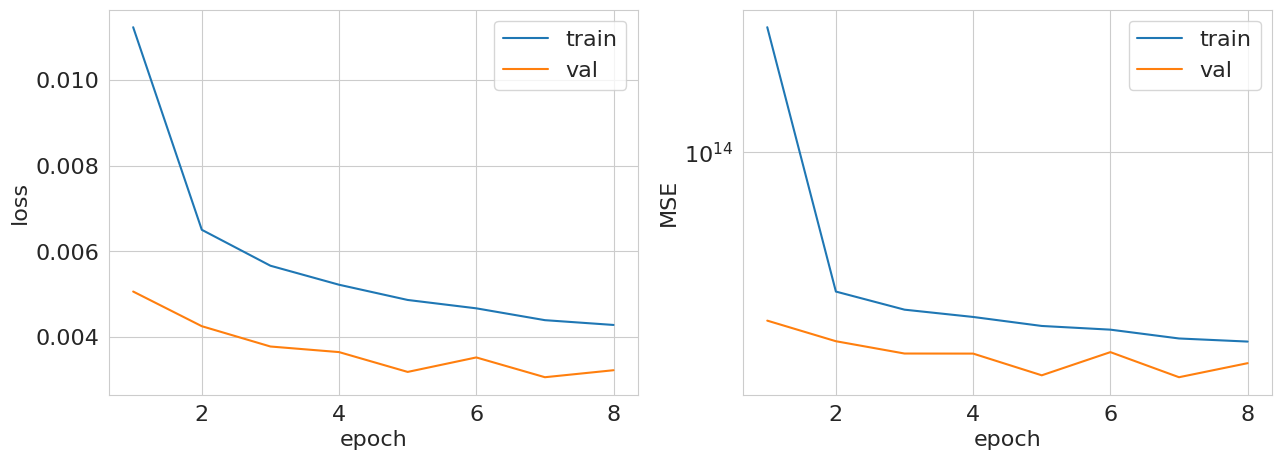

Validation MSE: 19105158818082.438


In [117]:
optimized_lr =0.01
model = LinearNetSigmoidEnhancedDropOut()
optimizer = optim.SGD(model.parameters(), lr=optimized_lr, momentum=0.8, weight_decay=0)
criterion = nn.MSELoss()

#y_train_scaled = pd.Series(y_train_scaled.flatten(), name='Цена')
train_dataset = X_train_scaled.copy().reset_index(drop=True)
train_dataset['Цена'] = y_train_scaled
train_dataset = MyDataset(train_dataset, target_col='Цена')
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

#y_test_scaled = pd.Series(y_test_scaled.flatten(), name='Цена')
test_dataset = X_test_scaled.copy().reset_index(drop=True)
test_dataset['Цена'] = y_test_scaled
test_dataset = MyDataset(test_dataset, target_col='Цена')
test_loader = DataLoader(test_dataset, batch_size=32)

train_mse, val_mse = train_and_validate(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    metric=lambda predictions, y_batch: torch.mean(
        (torch.exp(denormalize(predictions.float(), y_scaler)) - torch.exp(denormalize(y_batch.float(), y_scaler))) ** 2
    ),
    train_loader=train_loader,
    val_loader=test_loader,
    num_epochs=8,
    verbose=True
)

In [118]:
print(math.sqrt(val_mse))

4370944.842717926


ВЫВОД:
* При текущей архитектуре RMSE по качеству превосходит только базовую Ridge модель
* Необходимо больше времени и ресурсов на эксперимент, чтобы точно убедиться, что классические ML подходы лучше в задаче предсказания стоимости квартиры